In [1]:
#https://github.com/OceanParcels/GlobalMassBudget/blob/main/create_population_input.py

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [2]:
import pandas as pd
import urllib.request as urlr

import shapely as sh
import cartopy.io.shapereader as shpreader

In [3]:
def distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1r = np.radians(lon1)
    lat1r = np.radians(lat1)
    lon2r = np.radians(lon2)
    lat2r = np.radians(lat2)

    #Implementing Haversine Formula:
    dlon = np.subtract(lon2r, lon1r)
    dlat = np.subtract(lat2r, lat1r)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
                          np.multiply(np.cos(lat1r),
                                      np.multiply(np.cos(lat2r),
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))

    c = np.multiply(2, np.arcsin(np.sqrt(a)))
    r = 6371

    return c*r


def get_coords_from_polygon(shape):
    """
    Get a list of coordinate points on a Polygon
    (or MultiPolygon) shape
    """
    coords = []

    if isinstance(shape, sh.geometry.Polygon):
        coords.append(np.asarray(shape.exterior.coords[:-1]))
        for linearring in shape.interiors:
            coords.append(np.asarray(linearring.coords[:-1]))
    elif isinstance(shape, sh.geometry.MultiPolygon):
        #polygons = list(shape)
        for polygon in shape.geoms:
            coords.append(get_coords_from_polygon(polygon))
    coords = np.concatenate(coords)
    return coords

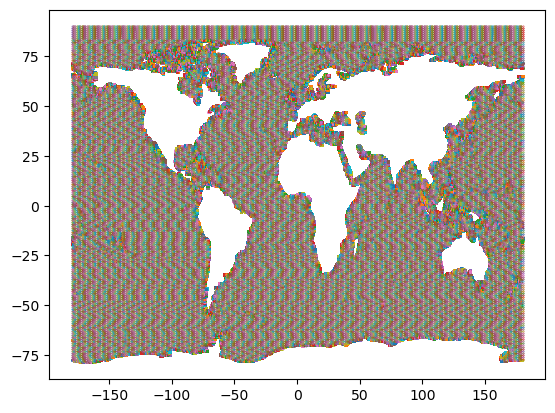

In [48]:
# Load Natural Earth dataset and plot country boundaries
# shpfilename = shpreader.natural_earth(resolution='10m',
#                                       category='physical',
#                                       name='ne_10m_bathymetry_L_0')
#https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_bathymetry_L_0.zip
reader = shpreader.Reader('/Users/denes001/Downloads/water-polygons-split-4326/water_polygons.shp')#shpfilename)
countries = reader.records()

for country in countries:
    try:
        country_coords = get_coords_from_polygon(country.geometry)
        country_lons, country_lats = country_coords[:,0], country_coords[:,1] #= country.geometry.exterior.coords.xy
        
    except:
        country_coords = [country.geometry.x, country.geometry.y]
        country_lons = country_coords[0]
        country_lats = country_coords[1]
    
    plt.scatter(country_lons, country_lats, s=0.1)

plt.show()


In [43]:
country.

-90.56937776799992

## Assign coastal grid cells to a country and give it a (2020 year) population density (maximum of population density values in a 50km radius).

In [11]:
reader = shpreader.Reader(shpfilename)
countries = reader.records()
continent = []
region_un = []
subregion = []
region_wb = []

#coastal_density_df = pd.DataFrame(columns = ['Continent', 'Region', 'Subregion', 'Country', 'Longitude', 'Latitude', 'PopulationDensity'])
coastal_density_list = []
for country in countries:
    # Get country information
    continent = country.attributes['CONTINENT']
    region_un = country.attributes['REGION_UN']
    subregion = country.attributes['SUBREGION']
    country_name = country.attributes['NAME_LONG']

    country_coords = get_coords_from_polygon(country.geometry)
    country_lons, country_lats = country_coords[:,0], country_coords[:,1] #= country.geometry.exterior.coords.xy

    # Assign each point a population density
    population_densities = [] # Gives the pop. density for all country points
    for i in range(len(country_lons)):
        coastal_point = [country_lons[i], country_lats[i]]
        # Raster = 4 is the 2020 data, nearest neighbour find pop.density
        population_density = np.float32(gpw['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].sel(longitude=coastal_point[0], latitude=coastal_point[1], raster=4, method='nearest').values)
        population_densities.append(population_density)


    # Loop through country points to find coastal points within [specified] km
    all_coastal_indices_popdensity = []
    
    for i in range(len(country_lons)):
        distances = distance(np.repeat(country_lons[i], len(lons_coast)), np.repeat(country_lats[i], len(lats_coast)), lons_coast, lats_coast)
        coastal_indices = np.where(distances<=distance_threshhold)[0] # Coastal indices are those that are within the thresshold distance
        all_coastal_indices_popdensity.append(np.array([coastal_indices, np.repeat(population_densities[i], len(coastal_indices))]).T) # Get coastal index and save the population density for this too
    
    #Concat into one big list
    all_coastal_indices_popdensity = np.vstack(all_coastal_indices_popdensity)
    # Sort by first column then second column backwards (so largest number is first)
    all_coastal_indices_popdensity = all_coastal_indices_popdensity[np.lexsort((all_coastal_indices_popdensity[:,0], all_coastal_indices_popdensity[:,1]))][::-1] 

    # Identify unique coastal indices with largest assigned population density
    all_coastal_indices_popdensity = all_coastal_indices_popdensity[np.unique(all_coastal_indices_popdensity,axis=0,return_index=True)[1]]
    all_coastal_indices = np.int32(all_coastal_indices_popdensity[:,0])
    all_popdensity = all_coastal_indices_popdensity[:,1]

    # For all coastal points assigned to country, find the population density at said point
    country_coastal_density_list = []
    for i in range(len(all_coastal_indices)):
        coastal_id = all_coastal_indices[i]
        coastal_point = [lons_coast[coastal_id], lats_coast[coastal_id]]
        # Raster = 4 is the 2020 data, nearest neighbour find pop.density
        # Grid range
        grid_range = 0.083 # roughly the cell width
        # Compute the population density as the maximum population density around the coastal cell (so that it's not taking a 0 if the cell center is closes to water)
        # Because the grid is ordered longitude ascencding, latitude descending, the slice ordering is swapped for lat
        population_density = np.float32(gpw['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].sel(longitude=slice(coastal_point[0]-grid_range,coastal_point[0]+grid_range), latitude=slice(coastal_point[1]+grid_range,coastal_point[1]-grid_range), raster=4).max())
        
        #For single point selection and not max over a grid:
        #population_density = np.float32(gpw['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].sel(longitude=coastal_point[0], latitude=coastal_point[1], raster=4, method='nearest').values)

        country_coastal_density_list.append({'Continent': continent,
                                                'Region': region_un,
                                                'Subregion': subregion,
                                                'Country': country_name,
                                                'Longitude': coastal_point[0],
                                                'Latitude': coastal_point[1],
                                                'PopulationDensity':all_popdensity[i]})
    
    country_coastal_density_df = pd.DataFrame.from_records(country_coastal_density_list)
    coastal_density_list.append(country_coastal_density_df)

    print(country_name, "added")
    

Zimbabwe added
Zambia added
Yemen added
Vietnam added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Venezuela added
Vatican added
Vanuatu added
Uzbekistan added
Uruguay added
Federated States of Micronesia added
Marshall Islands added
Northern Mariana Islands added
United States Virgin Islands added
Guam added
American Samoa added
Puerto Rico added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


United States added
South Georgia and the Islands added
British Indian Ocean Territory added
Saint Helena added
Pitcairn Islands added
Anguilla added
Falkland Islands / Malvinas added
Cayman Islands added
Bermuda added
British Virgin Islands added
Turks and Caicos Islands added
Montserrat added
Jersey added
Guernsey added
Isle of Man added
United Kingdom added
United Arab Emirates added
Ukraine added
Uganda added
Turkmenistan added
Turkey added
Tunisia added
Trinidad and Tobago added
Tonga added
Togo added
Timor-Leste added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Thailand added
Tanzania added
Tajikistan added
Taiwan added
Syria added
Switzerland added
Sweden added
Kingdom of eSwatini added
Suriname added
South Sudan added
Sudan added
Sri Lanka added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Spain added
Republic of Korea added
South Africa added
Somalia added
Somaliland added
Solomon Islands added
Slovakia added
Slovenia added
Singapore added
Sierra Leone added
Seychelles added
Serbia added
Senegal added
Saudi Arabia added
São Tomé and Principe added
San Marino added
Samoa added
Saint Vincent and the Grenadines added
Saint Lucia added
Saint Kitts and Nevis added
Rwanda added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Russian Federation added
Romania added
Qatar added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Portugal added
Poland added
Philippines added
Peru added
Paraguay added
Papua New Guinea added
Panama added
Palau added
Pakistan added
Oman added
Norway added
Dem. Rep. Korea added
Nigeria added
Niger added
Nicaragua added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


New Zealand added
Niue added
Cook Islands added
Netherlands added
Aruba added
Curaçao added
Nepal added
Nauru added
Namibia added
Mozambique added
Morocco added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Western Sahara added
Montenegro added
Mongolia added
Moldova added
Monaco added
Mexico added
Mauritius added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Mauritania added
Malta added
Mali added
Maldives added
Malaysia added
Malawi added
Madagascar added
North Macedonia added
Luxembourg added
Lithuania added
Liechtenstein added
Libya added
Liberia added
Lesotho added
Lebanon added
Latvia added
Lao PDR added
Kyrgyzstan added
Kuwait added
Kosovo added
Kiribati added
Kenya added
Kazakhstan added
Jordan added
Japan added
Jamaica added
Italy added
Israel added
Palestine added
Ireland added
Iraq added
Iran added
Indonesia added
India added
Iceland added
Hungary added
Honduras added
Haiti added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Guyana added
Guinea-Bissau added
Guinea added
Guatemala added
Grenada added
Greece added
Ghana added
Germany added
Georgia added
The Gambia added
Gabon added
France added
Saint Pierre and Miquelon added
Wallis and Futuna Islands added
Saint-Martin added
Saint-Barthélemy added
French Polynesia added
New Caledonia added
French Southern and Antarctic Lands added
Åland Islands added
Finland added
Fiji added
Ethiopia added
Estonia added
Eritrea added
Equatorial Guinea added
El Salvador added
Egypt added
Ecuador added
Dominican Republic added
Dominica added
Djibouti added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Greenland added
Faeroe Islands added
Denmark added
Czech Republic added
Northern Cyprus added
Cyprus added
Cuba added
Croatia added
Côte d'Ivoire added
Costa Rica added
Democratic Republic of the Congo added
Republic of the Congo added
Comoros added
Colombia added
China added
Macao added
Hong Kong added
Chile added
Chad added
Central African Republic added
Republic of Cabo Verde added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Canada added
Cameroon added
Cambodia added
Myanmar added
Burundi added
Burkina Faso added
Bulgaria added
Brunei Darussalam added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Brazil added
Botswana added
Bosnia and Herzegovina added
Bolivia added
Bhutan added
Benin added
Belize added
Belgium added
Belarus added
Barbados added
Bangladesh added
Bahrain added
Bahamas added
Azerbaijan added
Austria added
Australia added
Indian Ocean Territories added
Heard I. and McDonald Islands added
Norfolk Island added
Ashmore and Cartier Islands added
Armenia added
Argentina added
Antigua and Barbuda added
Angola added
Andorra added
Algeria added
Albania added
Afghanistan added
Siachen Glacier added


/var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/ipykernel_49646/995643120.py:22: RuntimeWarning: invalid value encountered in arcsin
  c = np.multiply(2, np.arcsin(np.sqrt(a)))


Antarctica added
Sint Maarten added
Tuvalu added


In [12]:
# Save output

coastal_density_df = pd.concat(coastal_density_list)
output_data = '../../data/release/generated_files/'
coastal_density_df.to_csv(output_data+'coastal_population_density_NEMO0083.csv')

## Plot output

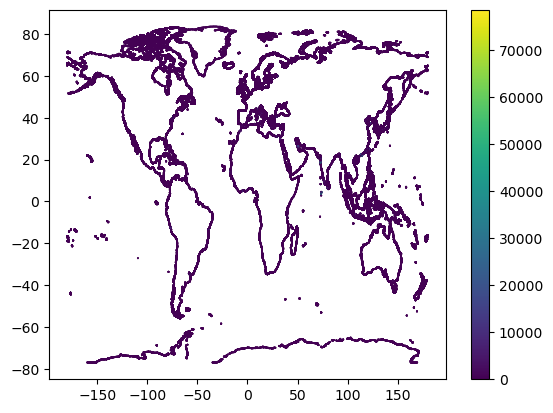

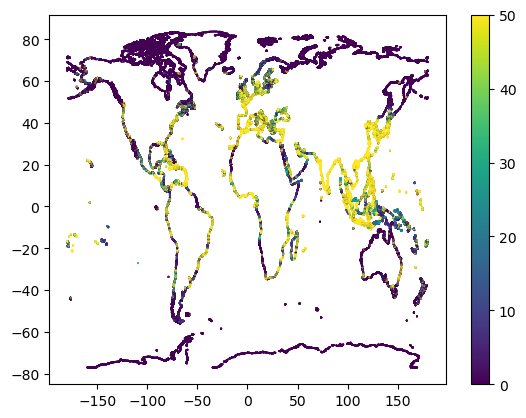

In [13]:
plt.scatter(coastal_density_df['Longitude'], coastal_density_df['Latitude'], c=coastal_density_df['PopulationDensity'], s=0.1)
plt.colorbar()
plt.show()
plt.scatter(coastal_density_df['Longitude'], coastal_density_df['Latitude'], c=coastal_density_df['PopulationDensity'], s=0.1, vmax=50)
plt.colorbar()
plt.show()


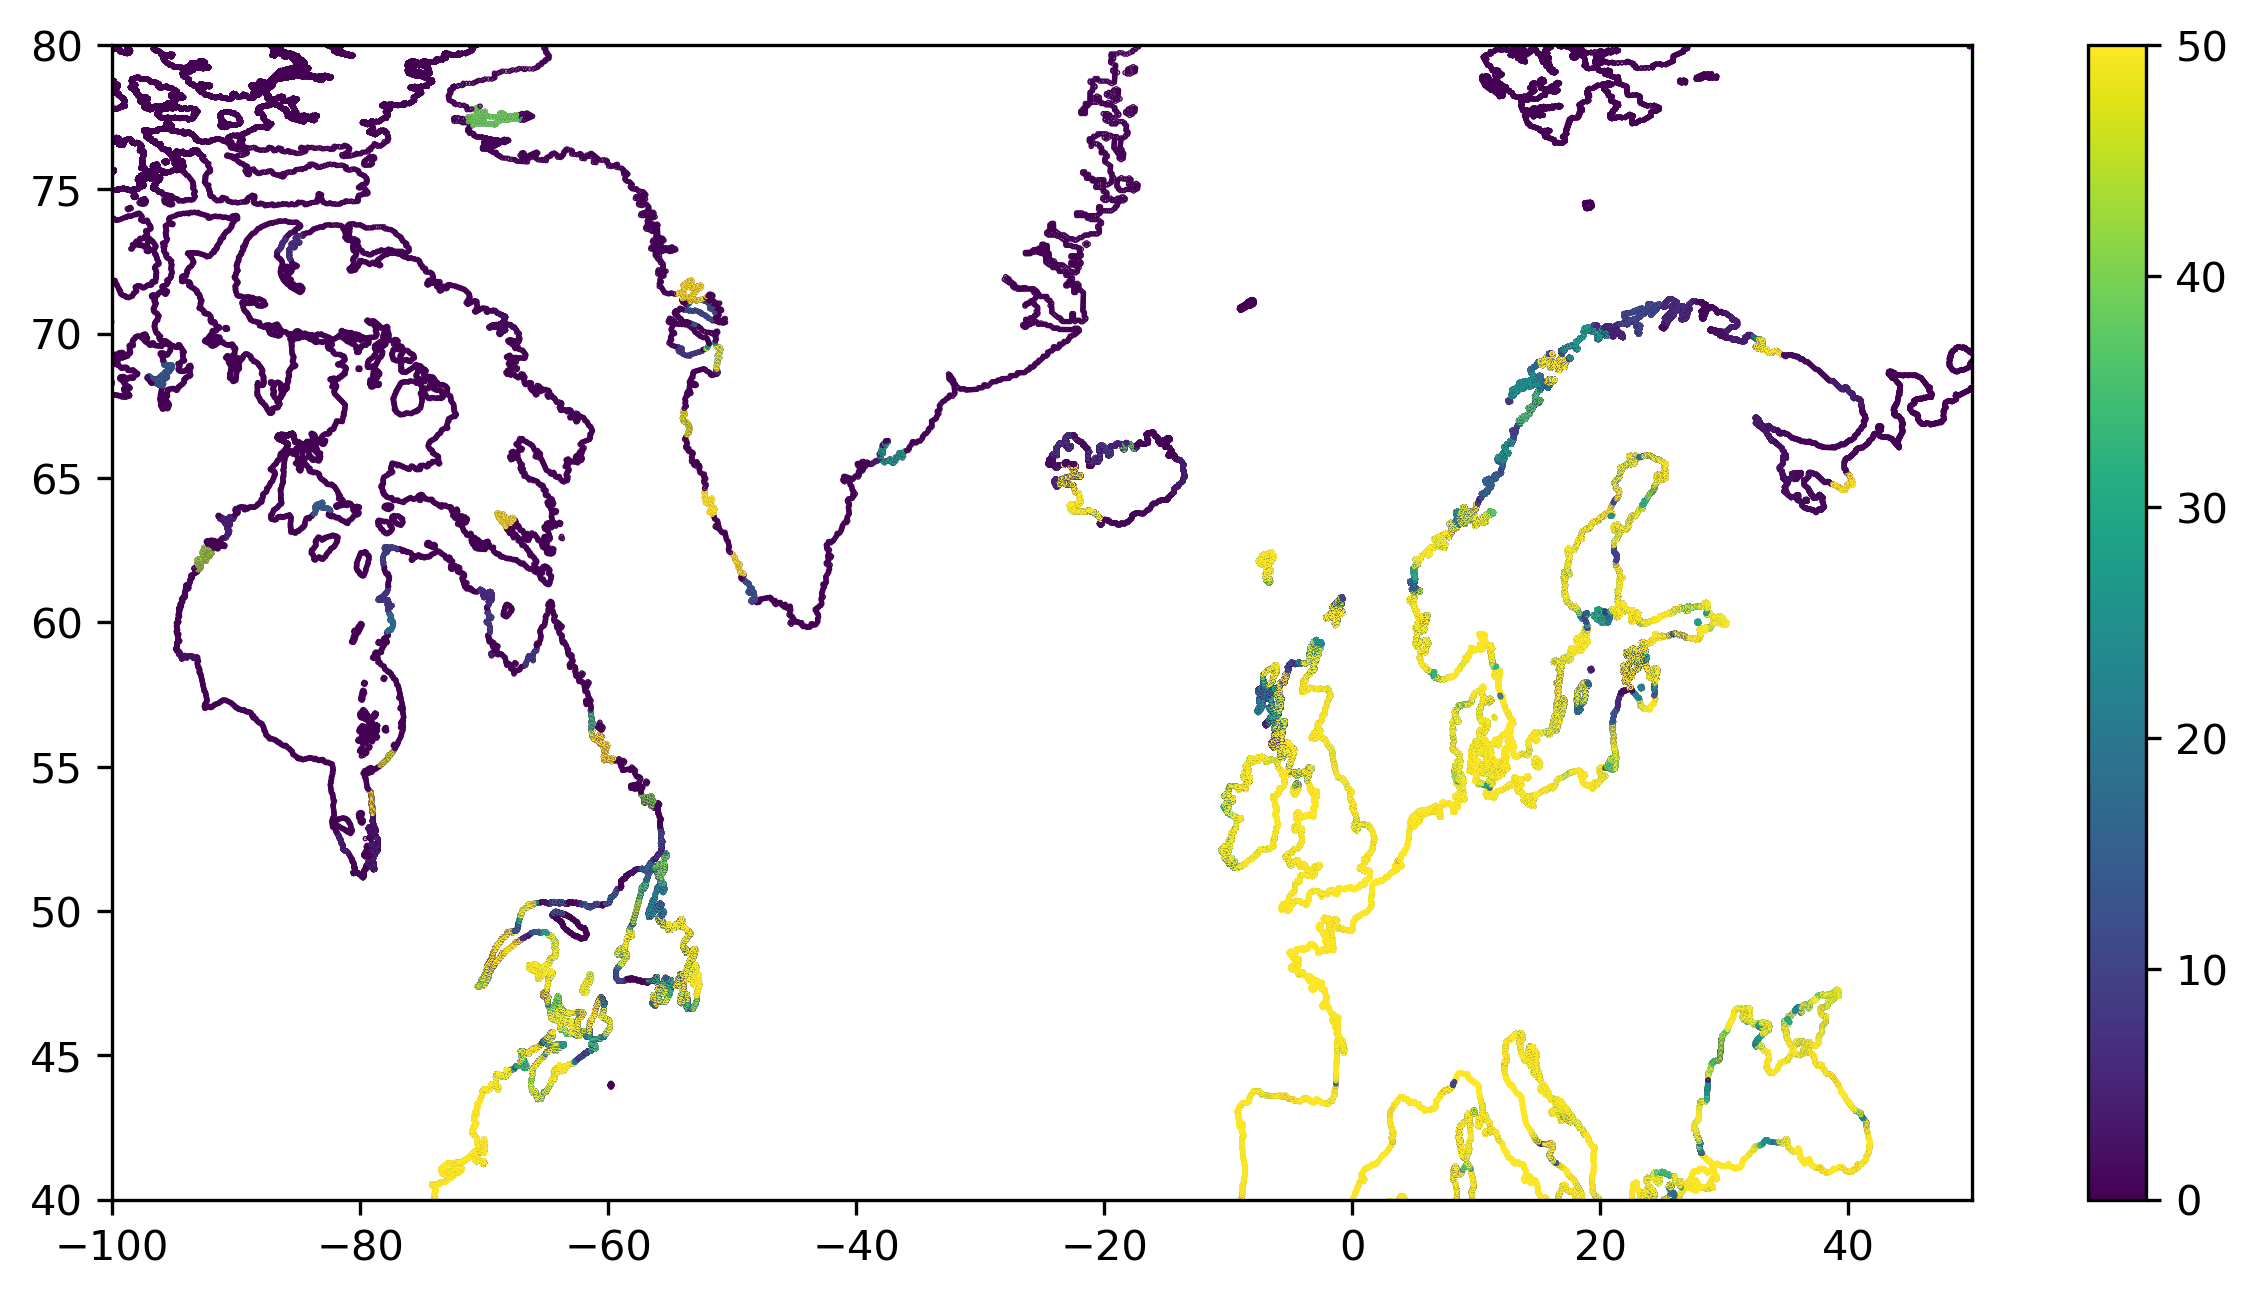

In [14]:
plt.figure(figsize=(10,5), dpi=300)
plt.scatter(coastal_density_df['Longitude'], coastal_density_df['Latitude'], c=coastal_density_df['PopulationDensity'], s=0.1, vmax=50)
plt.xlim([-100,50])
plt.ylim([40,80])
plt.colorbar()
plt.show()


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


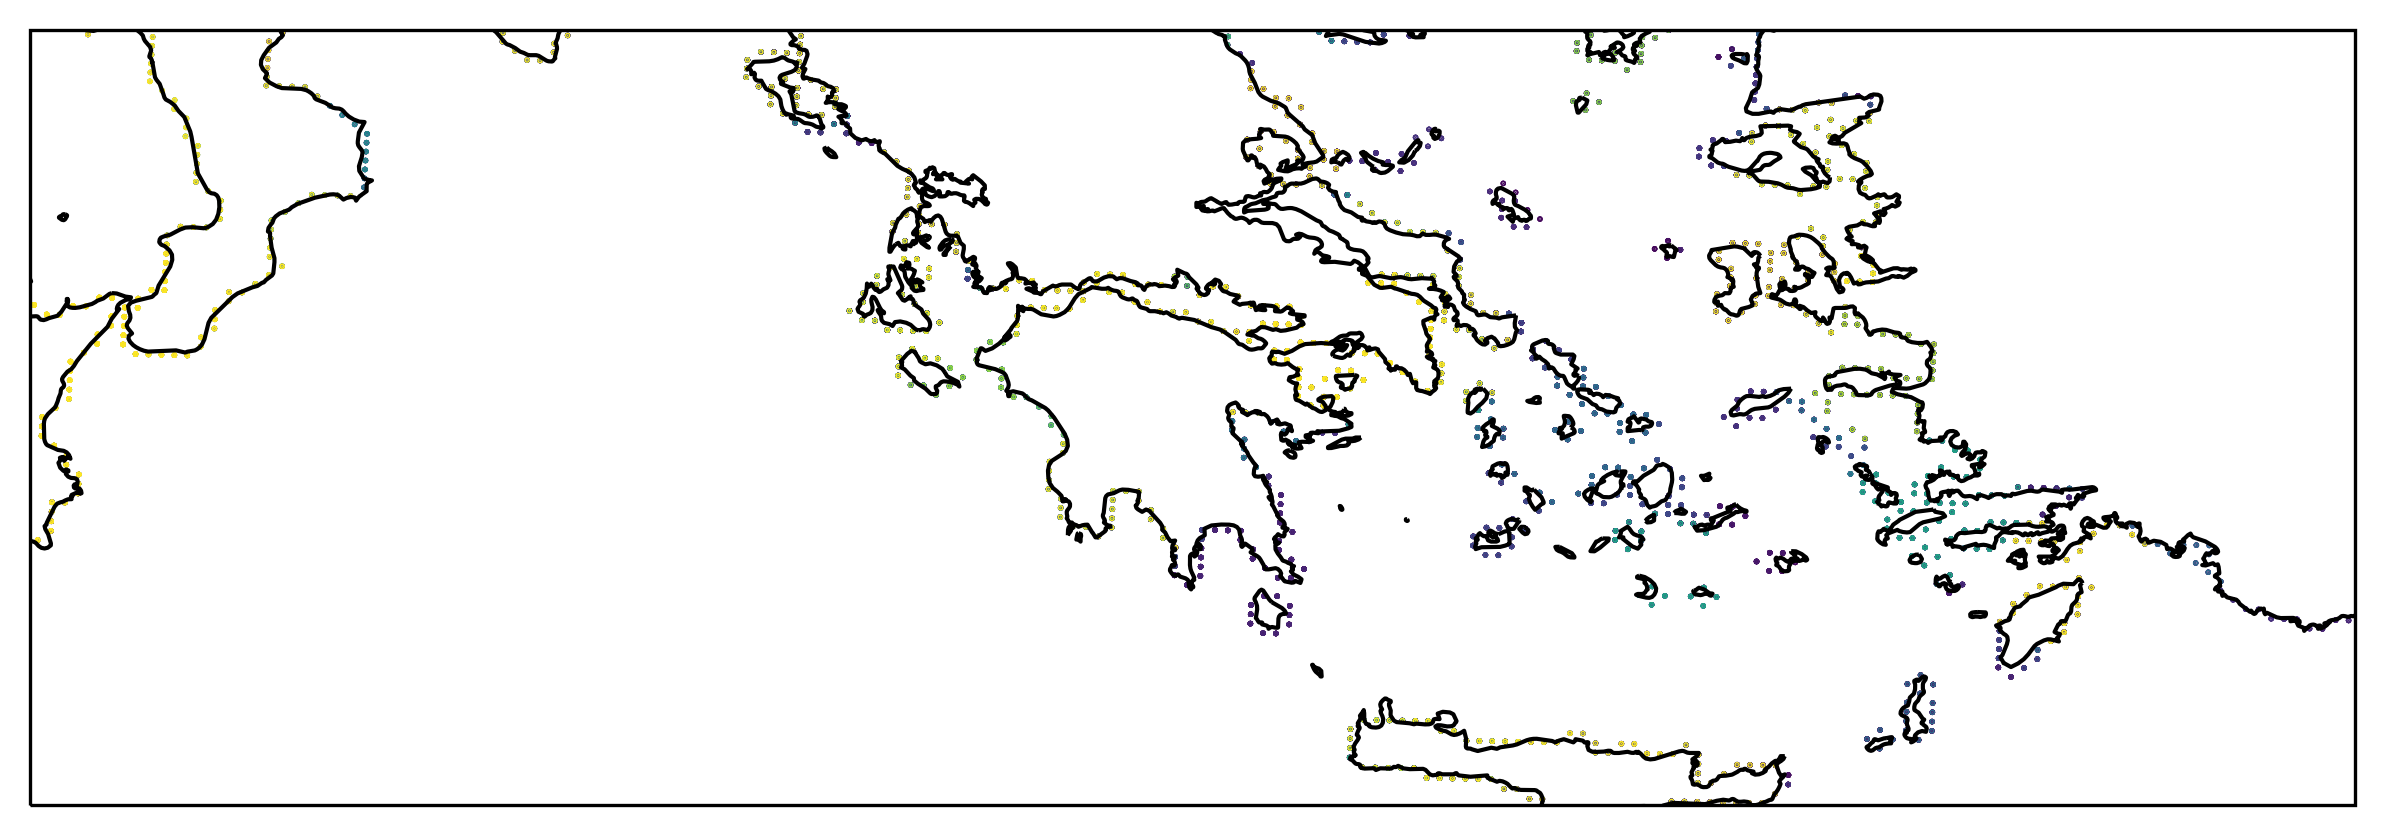

In [15]:
plt.figure(figsize=(10,5), dpi=300)
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.scatter(coastal_density_df['Longitude'], coastal_density_df['Latitude'], c=coastal_density_df['PopulationDensity'], s=0.1, vmax=500)
ax.set_xlim([15,30])
ax.set_ylim([35,40])
ax.coastlines()
plt.show()


In [16]:
# Load in coast mask
data_mask_land = xr.open_dataset('../../data/output_data/masks/mask_land_NEMO0083.nc')
lats_land = data_mask_land['lat'].data[np.where(data_mask_land['mask_land'])]
lons_land = data_mask_land['lon'].data[np.where(data_mask_land['mask_land'])]

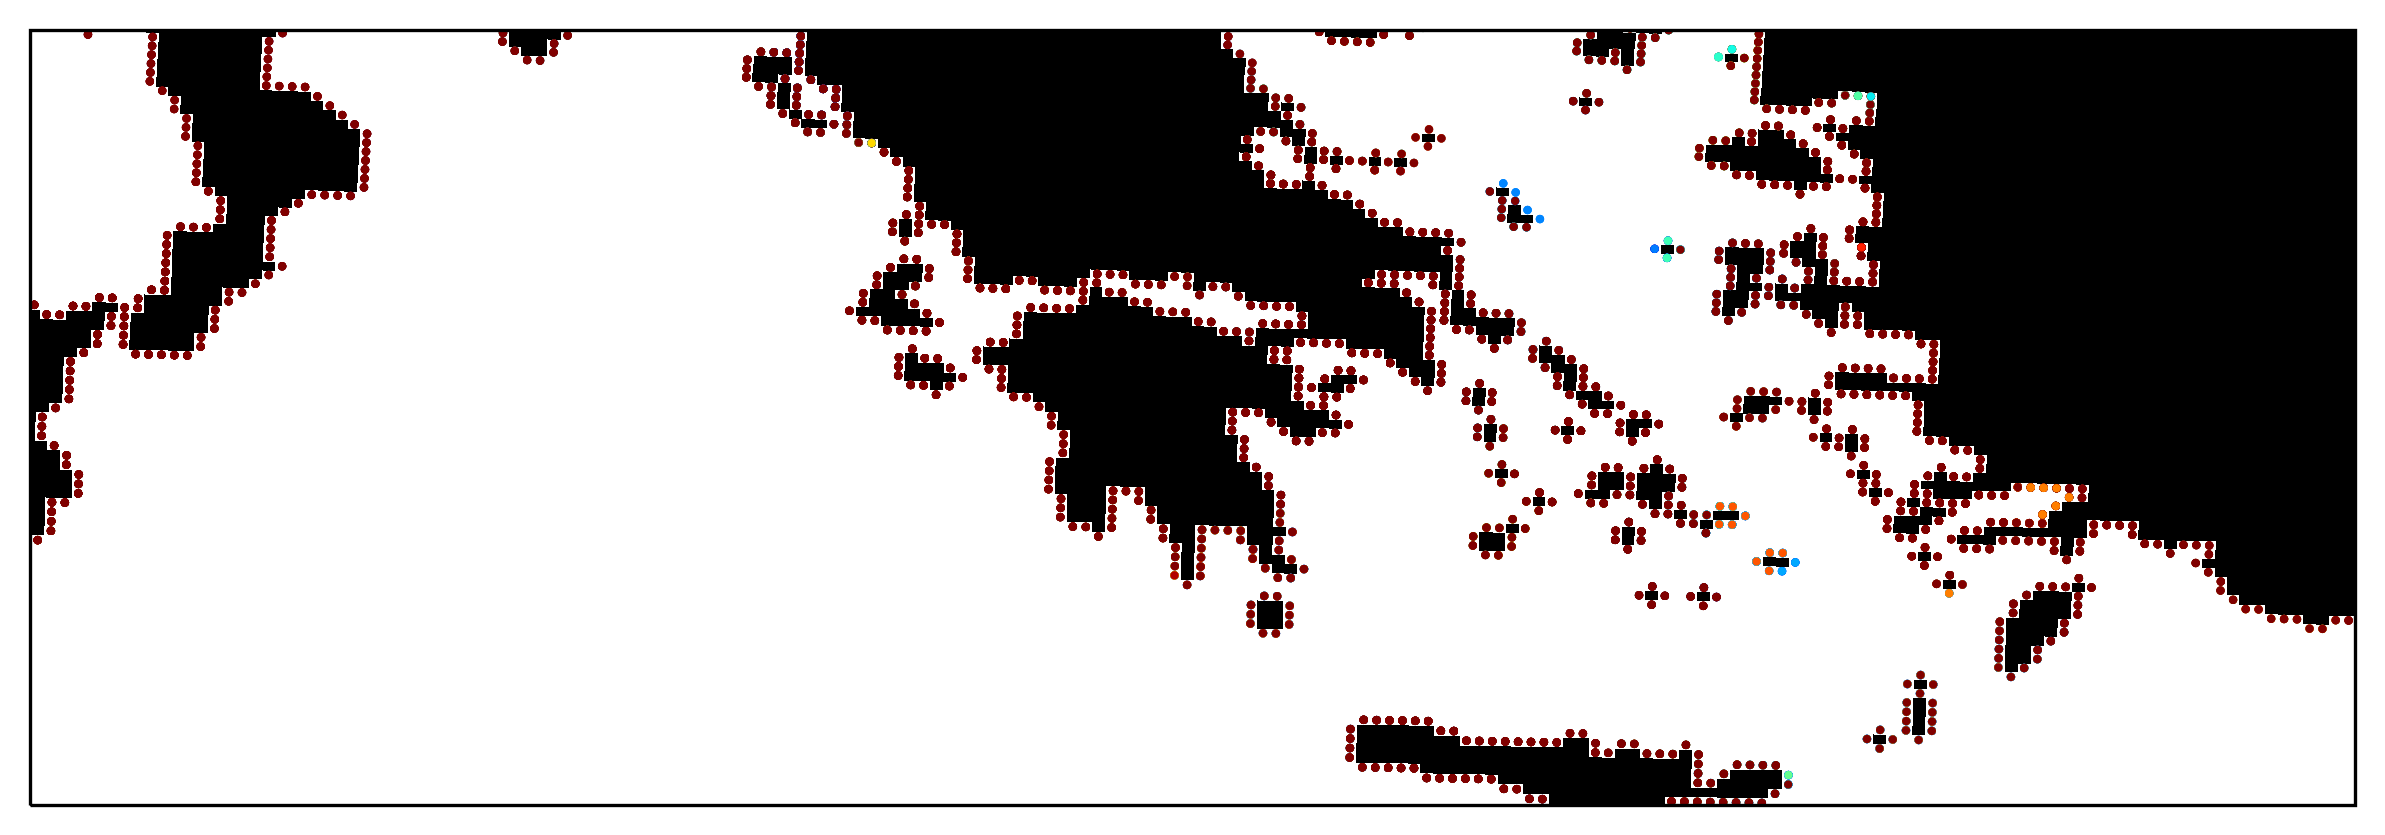

In [25]:
plt.figure(figsize=(10,5), dpi=300)
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.pcolormesh(data_mask_land['lon'], data_mask_land['lat'], data_mask_land['mask_land'], cmap=plt.cm.binary)
ax.scatter(coastal_density_df['Longitude'], coastal_density_df['Latitude'], c=coastal_density_df['PopulationDensity'], s=1, vmax=50, cmap=plt.cm.jet)
ax.set_xlim([15,30])
ax.set_ylim([35,40])
#ax.coastlines()
plt.show()


In [26]:
coastal_density_df

,Continent,Region,Subregion,Country,Longitude,Latitude,PopulationDensity
0,Asia,Asia,Western Asia,Yemen,53.583332,12.239177,11.609143
1,Asia,Asia,Western Asia,Yemen,53.583332,12.239177,11.688319
2,Asia,Asia,Western Asia,Yemen,53.583332,12.239177,17.718027
3,Asia,Asia,Western Asia,Yemen,53.583332,12.239177,17.718029
4,Asia,Asia,Western Asia,Yemen,53.666668,12.239177,11.688319
...,...,...,...,...,...,...,...
17,North America,Americas,Caribbean,Sint Maarten,-62.666668,17.949007,796.735962
18,North America,Americas,Caribbean,Sint Maarten,-62.750000,18.028267,311.001648
19,North America,Americas,Caribbean,Sint Maarten,-62.750000,18.028267,576.268433
20,North America,Americas,Caribbean,Sint Maarten,-62.750000,18.028267,692.616211


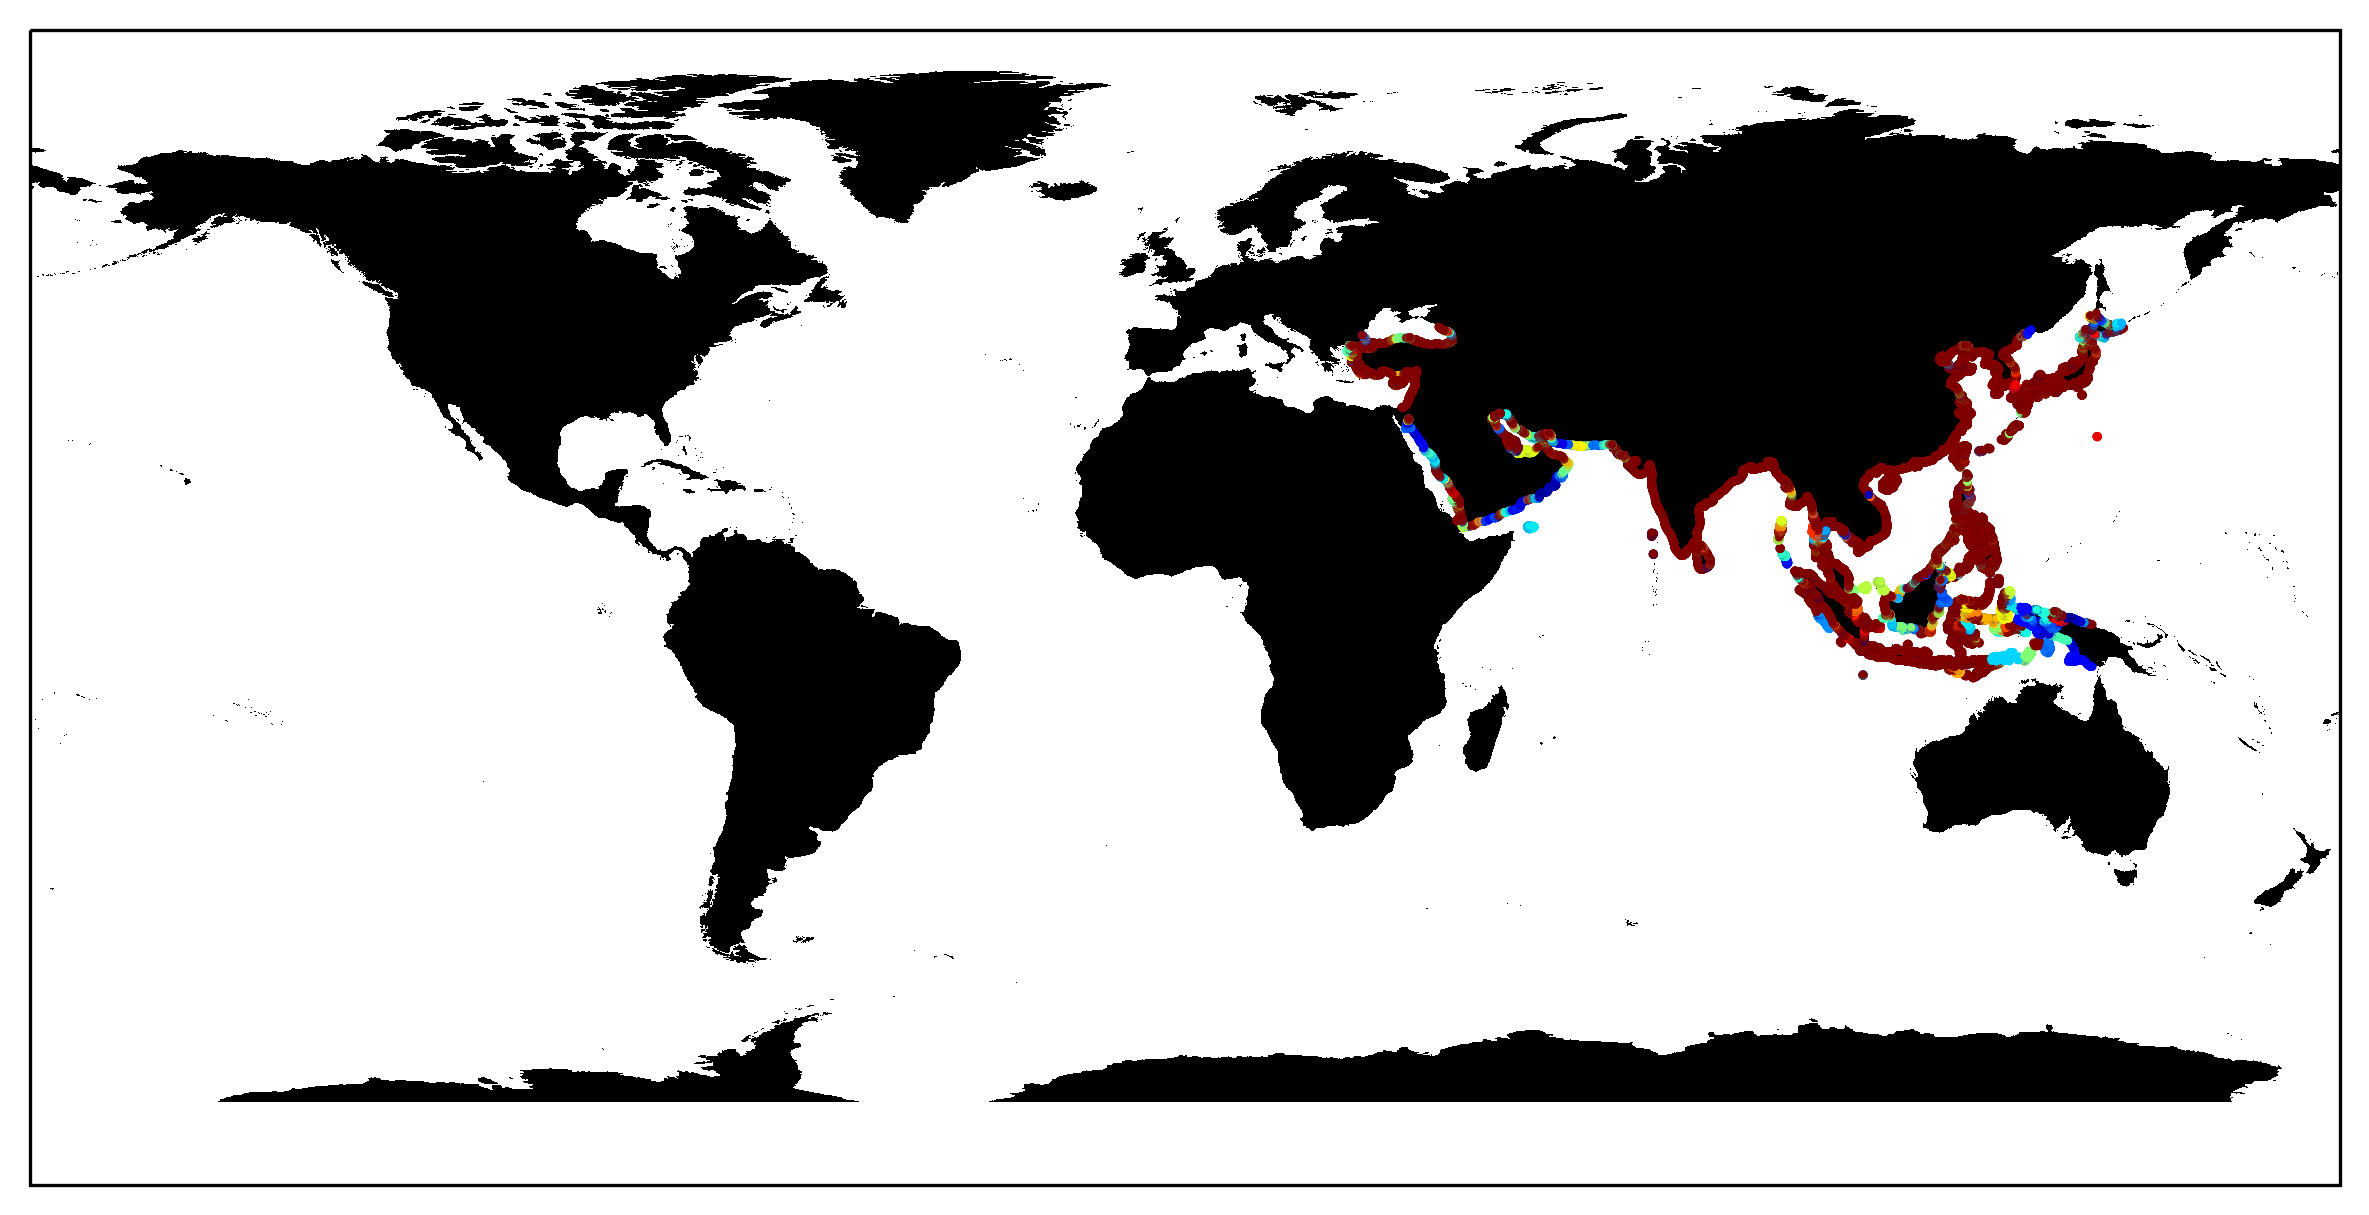

In [30]:
plt.figure(figsize=(10,5), dpi=300)
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.pcolormesh(data_mask_land['lon'], data_mask_land['lat'], data_mask_land['mask_land'], cmap=plt.cm.binary)
asia = (coastal_density_df['Continent']== 'Asia')
ax.scatter(coastal_density_df[asia]['Longitude'], coastal_density_df[asia]['Latitude'], c=coastal_density_df[asia]['PopulationDensity'], s=1, vmax=50, cmap=plt.cm.jet)

#ax.coastlines()
plt.show()


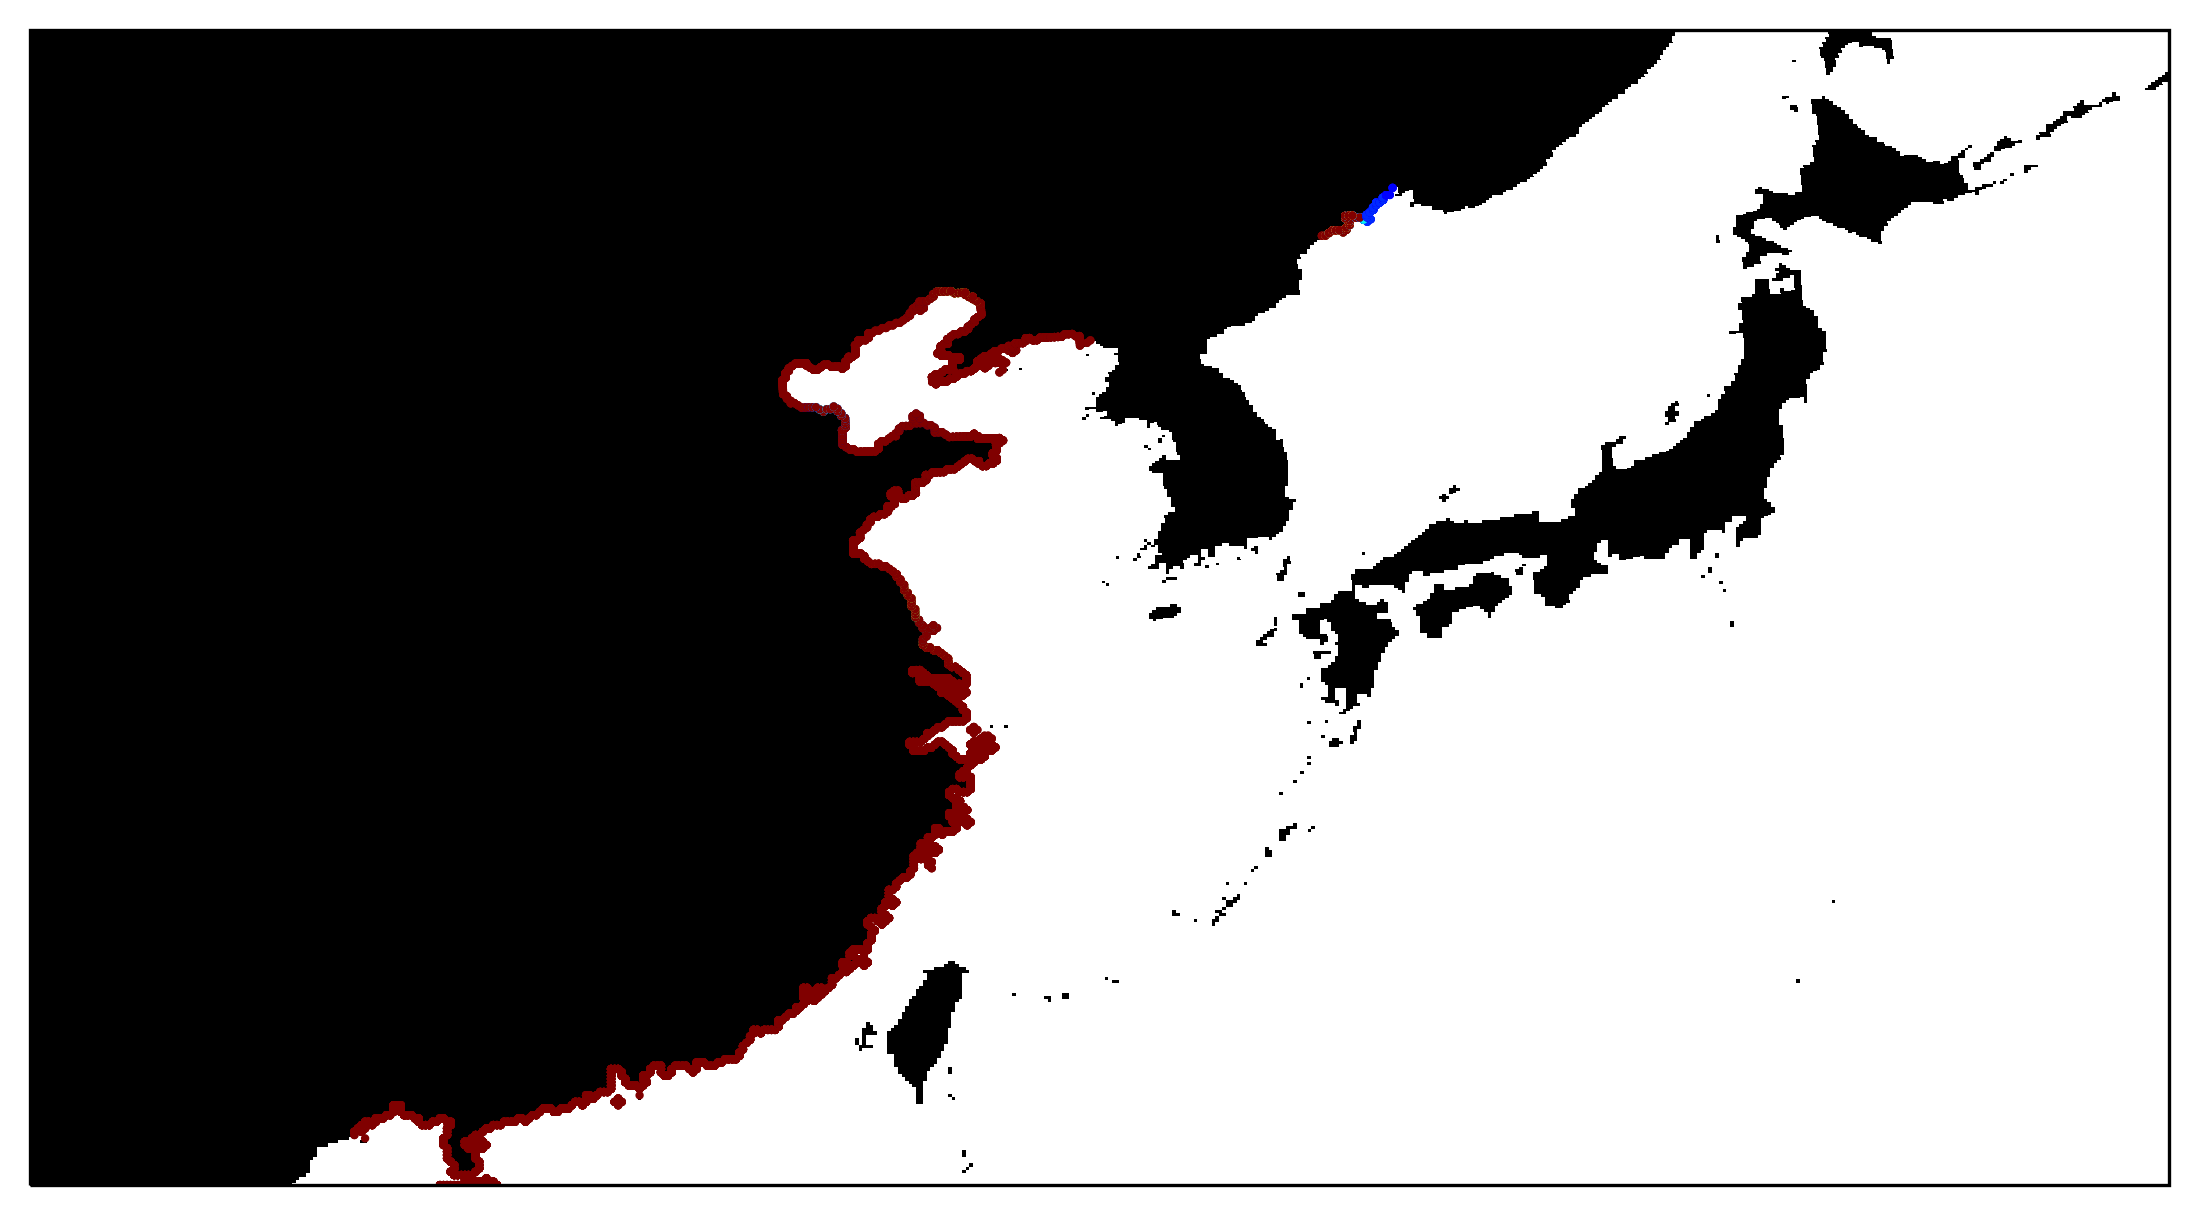

In [33]:
plt.figure(figsize=(10,5), dpi=300)
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.pcolormesh(data_mask_land['lon'], data_mask_land['lat'], data_mask_land['mask_land'], cmap=plt.cm.binary)
china = (coastal_density_df['Country'] == 'China')
ax.scatter(coastal_density_df[china]['Longitude'], coastal_density_df[china]['Latitude'], c=coastal_density_df[china]['PopulationDensity'], s=1, vmax=50, cmap=plt.cm.jet)
ax.set_xlim([100,150])
ax.set_ylim([20,47])
#ax.coastlines()
plt.show()


## Compute area of grid-cells and match to Jambeck data to get kg/day for each gridcell

In [ ]:
#TODO